# Schematics

In [1]:
import os
from typing import NamedTuple

from mygene import MyGeneInfo
import numpy as np
import pandas as pd

from tools.preferences import kwarg_savefig

In [2]:
class Config(NamedTuple):
    export: str = "/home/jovyan/output/schematics"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)

In [3]:
# glia markers
glia = ["SLC1A2", "VIM", "AQP4"]

In [4]:
from grnet.dev import multi_union

In [5]:
from typing import Any

def fmt(x: Any) -> list:
    return x if isinstance(x, list) else [x]

def go_union(
    markers: list,
    species: str = "human"
):
    golist = MyGeneInfo().querymany(
        markers,
        scopes="symbol", fields="go",
        species=species
    )
    return multi_union([
        np.concatenate(
            [fmt(v) for v in dic["go"].values()]
        ) for dic in golist
    ])

In [6]:
def goid2sym(
    goid: str,
    species: str = "human"
) -> pd.DataFrame:
    query_values = pd.DataFrame(
        list(
            MyGeneInfo().query(
                goid,
                scopes="go", 
                fields="symbol",
                species=species,
                fetch_all = True
            )
        )
    )
    return pd.DataFrame({
        "id": [goid for i in range(len(query_values))],
        "symbol": query_values.symbol 
    })

In [7]:
def alluvial_df(
    markers: list,
    species: str = "human",
    mask: bool = False,
    masked_symbol: str = "Others"
) -> pd.DataFrame:
    f = lambda arr, key: [v[key] for v in arr]
    lst_df = []
    for m in markers:
        go = f(
            go_union(m, species=species), 
            "id"
        )
        df_go2sym = pd.concat([
            goid2sym(
                goid, 
                species=species
            ) for goid in go
        ])
        symbol = [m for i in range(len(df_go2sym))]
        mapped = [
            masked_symbol if (sym not in markers) & mask \
            else sym for sym in df_go2sym.symbol
        ]
        lst_df += [
            pd.DataFrame({
                "symbol": symbol,
                "id": df_go2sym.id,
                "mapped": mapped
            })
        ]
    return pd.concat(
        lst_df
    ).drop_duplicates().reset_index(drop=True)

In [8]:
%%capture
df_glia = alluvial_df(glia, mask=True)

INFO:biothings.client:querying 1-1...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Fetching 14 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 107 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 38 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 221 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 6 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 239 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 65 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 19 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.client:Fetching 15 gene(s) . . .
ERROR:biothings.client:No more results to return.
INFO:biothings.cli

In [9]:
df_glia

,symbol,id,mapped
0,SLC1A2,GO:0006750,Others
1,SLC1A2,GO:0006750,SLC1A2
2,SLC1A2,GO:0006811,Others
3,SLC1A2,GO:0006811,SLC1A2
4,SLC1A2,GO:0006836,Others
...,...,...,...
206,AQP4,GO:0005515,VIM
207,AQP4,GO:0005515,SLC1A2
208,AQP4,GO:0005515,AQP4
209,AQP4,GO:0015250,Others


In [10]:
import matplotlib.pyplot as plt

In [11]:
def rectangle_config(series):
    series = series.value_counts()[series.unique()]
    ratio = (
        series / series.sum()
    ).cumsum()
    bottom = (
        ratio - ratio.diff()
    ).fillna(0)
    return bottom, ratio

In [12]:
color_config = {
    "symbol": {
        v: f"C{i}" for i, v in enumerate(glia)
    },
    "id": {
        goid: plt.cm.rainbow(
            i / df_glia.id.unique().size
        ) for i, goid in enumerate(df_glia.id.unique())
    },
    "mapped": {
        v: f"C{i}" if v in glia else ".8" for i, v in enumerate(
            glia + ["Others"]
        )
    }
}

In [13]:
def alluvial_curve(
    y0: float,
    y1: float,
    n: int = 1000
):
    theta = np.linspace(0, np.pi, n)
    theta += np.pi if y1 > y0 else 0
    a = abs(y0 - y1) / (1 - -1)
    b = (y0 + y1) / 2
    return a * np.cos(theta) + b

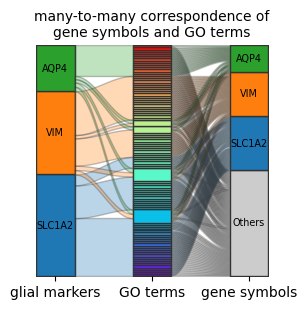

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.set_xlim([-.5, 2.5])

width = .4
for loc, key in enumerate(["symbol", "id", "mapped"]):
    x = np.array([-width/2, width/2]) + loc
    bottom, top = rectangle_config(
        df_glia.loc[:, key]
    )
    for i, v in enumerate(
        top.index
    ):
        ax.fill_between(
            x,
            top[v] * np.ones(x.size),
            bottom[v] * np.ones(x.size),
            color=color_config[key][v],
            edgecolor=".2"
        )
        ax.text(
            loc, np.mean([top[v], bottom[v]]), v,
            ha="center", va="center", size="x-small"
        ) if loc != 1 else None

bottom_loc, top_loc = rectangle_config(df_glia.index)

encoder = {
    **{
        v: i for i, v in enumerate(["Others"] + glia)
    },
    **{
        v: i for i, v in enumerate(df_glia.id.unique())
    }
}
df_encoded = df_glia.replace(
    encoder
).sort_values(
    list(df_glia.columns)
).reset_index(drop=True)

df_idx = pd.DataFrame({
    "symbol": df_encoded.index,
    "id": pd.concat([
        df_encoded[
            df_encoded.loc[:, "id"] == v
        ] for v in df_encoded.loc[:, "id"].unique()
    ]).assign(
        order=np.arange(len(df_encoded))
    ).sort_index().order,
    "mapped": pd.concat([
        df_encoded[
            df_encoded.loc[:, "mapped"] == v
        ] for v in df_encoded.loc[:, "mapped"].unique()
    ]).assign(
        order=np.arange(len(df_encoded))
    ).sort_index().order
})
        
# symbol -> id

for gm in glia:
    sep = df_idx[df_encoded["symbol"] == encoder[gm]]
    idxs = sep.id.diff().fillna(0)[
        sep.id.diff().fillna(0) != 1
    ].index
    for i in range(idxs.size):
        start, end = np.roll(idxs, -i)[:2]
        end = sep.index.max() if end < start else sep.index[
            np.where(
                sep.index == end
            )[0].item() - 1
        ]
        bottom0 = bottom_loc[df_idx.symbol[start]]
        bottom1 = bottom_loc[df_idx.id[start]]
        top0 = top_loc[df_idx.symbol[end]]
        top1 = top_loc[df_idx.id[end]]
        ax.fill_between(
            np.linspace(.2, 1 - .2, 100),
            alluvial_curve(top0, top1, 100),
            alluvial_curve(bottom0, bottom1, 100),
            color=color_config["symbol"][gm], alpha=.3,
            edgecolor=".2"
        )

# mapped -> id

for sym in (["Others"] + glia):
    sep = df_idx[df_encoded["mapped"] == encoder[sym]]
    idxs = sep.id.diff().fillna(0)[
        sep.id.diff().fillna(0) != 1
    ].index
    for i in range(idxs.size):
        start, end = np.roll(idxs, -i)[:2]
        end = sep.index.max() if end < start else sep.index[
            np.where(
                sep.index == end
            )[0].item() - 1
        ]
        bottom0 = bottom_loc[df_idx.id[start]]
        bottom1 = bottom_loc[df_idx.mapped[start]]
        top0 = top_loc[df_idx.id[end]]
        top1 = top_loc[df_idx.mapped[end]]
        ax.fill_between(
            np.linspace(1 + .2, 2 - .2, 100),
            alluvial_curve(top0, top1, 100),
            alluvial_curve(bottom0, bottom1, 100),
            color=color_config["mapped"][sym], alpha=.3,
            edgecolor=".2"
        )

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([
    "glial markers", 
    "GO terms", 
    "gene symbols"
])
ax.set_ylim([0, 1])
ax.set_xlim([-.2, 2.2])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(
    axis='both', which='both', 
    top=False, left=False, right=False, 
    labelleft=False
)
ax.set_title(
    "many-to-many correspondence of\ngene symbols and GO terms",
    size="medium"
)

fig.savefig(
    f"{conf.export}/go_alluvial.png",
    **kwarg_savefig
)